# Modeling and Simulation in Python

Chapter 7

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter

In [2]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [3]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [4]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [5]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [6]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

### Quadratic growth

Here's the implementation of the quadratic growth model.

In [28]:
def update_func_quad(pop, t, system):
    """Compute the population next year with a quadratic model.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

Here's a `System` object with the parameters `alpha` and `beta`:

In [29]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
alpha,0.025000
beta,-0.001800


And here are the results.

Saving figure to file figs/chap07-fig01.pdf


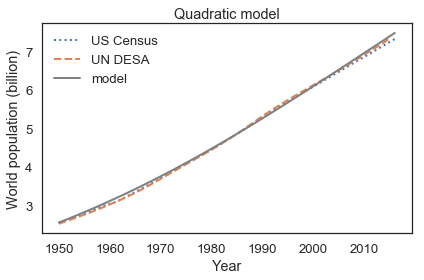

In [30]:
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')
savefig('figs/chap07-fig01.pdf')

**Exercise:**  Can you find values for the parameters that make the model fit better?

### Equilibrium

To understand the quadratic model better, let's plot net growth as a function of population.

In [10]:
pop_array = linspace(0, 15, 100)
net_growth_array = system.alpha * pop_array + system.beta * pop_array**2
None

Here's what it looks like.

Saving figure to file figs/chap07-fig02.pdf


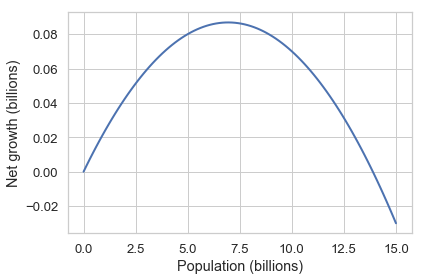

In [11]:
sns.set_style('whitegrid')

plot(pop_array, net_growth_array)
decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)')

sns.set_style('white')

savefig('figs/chap07-fig02.pdf')

Here's what it looks like.  Remember that the x axis is population now, not time.

It looks like the growth rate passes through 0 when the population is a little less than 14 billion.

In the book we found that the net growth is 0 when the population is $-\alpha/\beta$:

In [12]:
-system.alpha / system.beta

13.88888888888889

This is the equilibrium the population tends toward.

`sns` is a library called Seaborn which provides functions that control the appearance of plots.  In this case I want a grid to make it easier to estimate the population where the growth rate crosses through 0.

### Dysfunctions

When people first learn about functions, there are a few things they often find confusing.  In this section I present and explain some common problems with functions.

As an example, suppose you want a function that takes a `System` object, with variables `alpha` and `beta`, as a parameter and computes the carrying capacity, `-alpha/beta`.  Here's a good solution:

In [13]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

13.88888888888889


Now let's see all the ways that can go wrong.

**Dysfunction #1:** Not using parameters.  In the following version, the function doesn't take any parameters; when `sys1` appears inside the function, it refers to the object we created outside the function.


In [14]:
def carrying_capacity():
    K = -sys1.alpha / sys1.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity()
print(pop)

13.88888888888889


This version actually works, but it is not as versatile as it could be.  If there are several `System` objects, this function can only work with one of them, and only if it is named `system`.

**Dysfunction #2:** Clobbering the parameters.  When people first learn about parameters, they often write functions like this:

In [15]:
def carrying_capacity(system):
    system = System(alpha=0.025, beta=-0.0018)
    K = -system.alpha / system.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

13.88888888888889


In this example, we have a `System` object named `sys1` that gets passed as an argument to `carrying_capacity`.  But when the function runs, it ignores the argument and immediately replaces it with a new `System` object.  As a result, this function always returns the same value, no matter what argument is passed.

When you write a function, you generally don't know what the values of the parameters will be.  Your job is to write a function that works for any valid values.  If you assign your own values to the parameters, you defeat the whole purpose of functions.


**Dysfunction #3:** No return value.  Here's a version that computes the value of `K` but doesn't return it.

In [16]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

None


A function that doesn't have a return statement always returns a special value called `None`, so in this example the value of `pop` is `None`.  If you are debugging a program and find that the value of a variable is `None` when it shouldn't be, a function without a return statement is a likely cause.

**Dysfunction #4:** Ignoring the return value.  Finally, here's a version where the function is correct, but the way it's used is not.

In [17]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K
    
sys2 = System(alpha=0.025, beta=-0.0018)
carrying_capacity(sys2)

# print(K)     This line won't work because K only exists inside the function.

13.88888888888889

In this example, `carrying_capacity` runs and returns `K`, but the return value is dropped.

When you call a function that returns a value, you should do something with the result.  Often you assign it to a variable, as in the previous examples, but you can also use it as part of an expression.

For example, you could eliminate the temporary variable `pop` like this:

In [18]:
print(carrying_capacity(sys1))

13.88888888888889


Or if you had more than one system, you could compute the total carrying capacity like this:


In [19]:
total = carrying_capacity(sys1) + carrying_capacity(sys2)
total

27.77777777777778

## Exercises

**Exercise:** In the book, I present a different way to parameterize the quadratic model:

$ \Delta p = r p (1 - p / K) $

where $r=\alpha$ and $K=-\alpha/\beta$.  Write a version of `update_func` that implements this version of the model.  Test it by computing the values of `r` and `K` that correspond to `alpha=0.025, beta=-0.0018`, and confirm that you get the same results. 

In [39]:
# Solution goes here
def update_func(system):
    r = system.alpha
    K = -system.alpha / system.beta

    return K
    
sys3 = System(alpha = 0.025, beta = -0.0018)
net_growth = update_func(sys3)

13.88888888888889

In [27]:
# Solution goes here

In [ ]:
# Solution goes here